Hypothesis: During afternoon hours, I am more likely to watch romantic content on larger screens like TVs, while evenings see a higher viewership of comedies on PC devices.

# Preprocessing

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [3]:
file_path = 'netflixDataCSV.csv'

# Read the CSV file
df = pd.read_csv(file_path, delimiter=';')

In [4]:
# Drop columns with "Not latest view" value in Latest Bookmark column as they corrupt the data
df = df[df['Latest Bookmark'] != 'Not latest view']

# Convert 'Start Time' to datetime and extract date and time
df['Start Time'] = pd.to_datetime(df['Start Time'])
df['Date'] = df['Start Time'].dt.date
df['Time'] = df['Start Time'].dt.time

# Remove text after the first ':' in 'Title'
df['Title'] = df['Title'].apply(lambda x: x.split(':')[0])

# Convert 'Duration' to a uniform time format (in minutes)
df['Duration'] = df['Duration'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))
df['Bookmark'] = df['Bookmark'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))

df['Latest Bookmark'] = df['Latest Bookmark'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))

In [5]:
print(df.head)
print(df.info)
print(df.shape)

<bound method NDFrame.head of               Start Time  Duration                  Title  \
0    2023-11-29 11:05:00         9          Gilmore Girls   
1    2023-11-29 10:58:00         6          Gilmore Girls   
3    2023-11-20 22:01:00        43          Gilmore Girls   
4    2023-11-20 21:14:00        44          Gilmore Girls   
5    2023-11-20 20:27:00        36          Gilmore Girls   
...                  ...       ...                    ...   
1064 2019-11-02 11:21:00         5                    You   
1066 2019-11-01 18:22:00        49                    You   
1067 2019-11-01 17:24:00         7              Locked Up   
1068 2019-10-30 19:02:00       100  Friends with Benefits   
1070 2019-10-20 08:18:00        39                   Baby   

                              Device Type  Bookmark  Latest Bookmark  \
0                           iPhone 12 Pro        10               10   
1                           iPhone 12 Pro        43               43   
3     Netflix Chrome 

In [6]:
# Find different devices so that we can map them to more useful values manually
unique_device_types = df['Device Type'].unique()
print(unique_device_types)

['iPhone 12 Pro' 'Netflix Chrome MAC (Cadmium) HTML 5'
 'Apple iPad 10.2 inch 7th Gen Wi-Fi iPad'
 'Sony Sony Android TV 2018 M2 4K Smart TV' 'Safari MAC (Cadmium)'
 'Arcelik PerformMax D2 Smart TV' 'Apple iPhone 6s' 'Chrome PC (Cadmium)']


In [7]:
def map_device_type(device_type):
    if 'iPhone 12 Pro' in device_type or 'Apple iPhone 6s' in device_type:
        return 'Mobile'
    elif 'Apple iPad 10.2 inch 7th Gen Wi-Fi iPad' in device_type:
        return 'Tablet'
    elif 'Netflix Chrome MAC (Cadmium) HTML 5' in device_type or 'Safari MAC (Cadmium)' in device_type or 'Chrome PC (Cadmium)' in device_type:
        return 'PC'
    elif 'Sony Sony Android TV 2018 M2 4K Smart TV' in device_type or 'Arcelik PerformMax D2 Smart TV' in device_type:
        return 'TV'
    else:
        return 'other'

In [8]:
df['Device Category'] = df['Device Type'].apply(map_device_type)

In [9]:
# Add a column for part of the day based on 'Time'
def get_part_of_day(hour):
    return (
        "Morning" if 5 <= hour <= 11
        else "Afternoon" if 12 <= hour <= 17
        else "Evening" if 18 <= hour <= 22
        else "Night"
    )

In [10]:
df['Part of Day'] = df['Start Time'].dt.hour.apply(get_part_of_day)

In [11]:
print(df.head)

<bound method NDFrame.head of               Start Time  Duration                  Title  \
0    2023-11-29 11:05:00         9          Gilmore Girls   
1    2023-11-29 10:58:00         6          Gilmore Girls   
3    2023-11-20 22:01:00        43          Gilmore Girls   
4    2023-11-20 21:14:00        44          Gilmore Girls   
5    2023-11-20 20:27:00        36          Gilmore Girls   
...                  ...       ...                    ...   
1064 2019-11-02 11:21:00         5                    You   
1066 2019-11-01 18:22:00        49                    You   
1067 2019-11-01 17:24:00         7              Locked Up   
1068 2019-10-30 19:02:00       100  Friends with Benefits   
1070 2019-10-20 08:18:00        39                   Baby   

                              Device Type  Bookmark  Latest Bookmark  \
0                           iPhone 12 Pro        10               10   
1                           iPhone 12 Pro        43               43   
3     Netflix Chrome 

In [12]:
df.to_csv('file_name.csv')
# For manual inspection

# Analysis

We will start with Exploratory Data Analysis and focus on understanding the distributions, relationships, and trends in my Netflix streaming data. This will involve both statistical summaries and data visualizations.

In [13]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

In [14]:
# Display a statistical overview of the dataframe
print(df.describe(include='all'))

# Display information about data types and non-null values
print(df.info())

<ipython-input-14-94bdee6a8e9d>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(include='all'))


                 Start Time    Duration          Title  \
count                   775  775.000000            775   
unique                  764         NaN            172   
top     2023-04-06 20:45:00         NaN  Gilmore Girls   
freq                      2         NaN             30   
first   2019-10-20 08:18:00         NaN            NaN   
last    2023-11-29 11:05:00         NaN            NaN   
mean                    NaN   32.196129            NaN   
std                     NaN   24.124735            NaN   
min                     NaN    0.000000            NaN   
25%                     NaN   18.000000            NaN   
50%                     NaN   29.000000            NaN   
75%                     NaN   42.000000            NaN   
max                     NaN  135.000000            NaN   

                                     Device Type    Bookmark  Latest Bookmark  \
count                                        775  775.000000       775.000000   
unique                   

In [15]:
# Top types
type_exploded_df = df.assign(Type=df['Type'].str.split(', ')).explode('Type')

# Get the top 10 most frequent genres
top_types = type_exploded_df['Type'].value_counts().head(10)

print(top_types)

Emotional      204
Heartfelt      161
Suspenseful    156
Romantic       144
Quirky         122
Intimate       121
Witty           90
Bittersweat     81
Exciting        76
Nostalgic       49
Name: Type, dtype: int64


In [16]:
# Top genres
print(df['Genre'].value_counts().head(10))

Teen TV Shows             149
TV Dramas                 137
Romantic TV Dramas        129
Medical TV Shows           48
Sitcoms                    38
Sci-Fi TV Dramas           37
Docuseries                 36
Family Watch TV Shows      36
Competition Reality TV     26
Romantic Comedy Movies     23
Name: Genre, dtype: int64


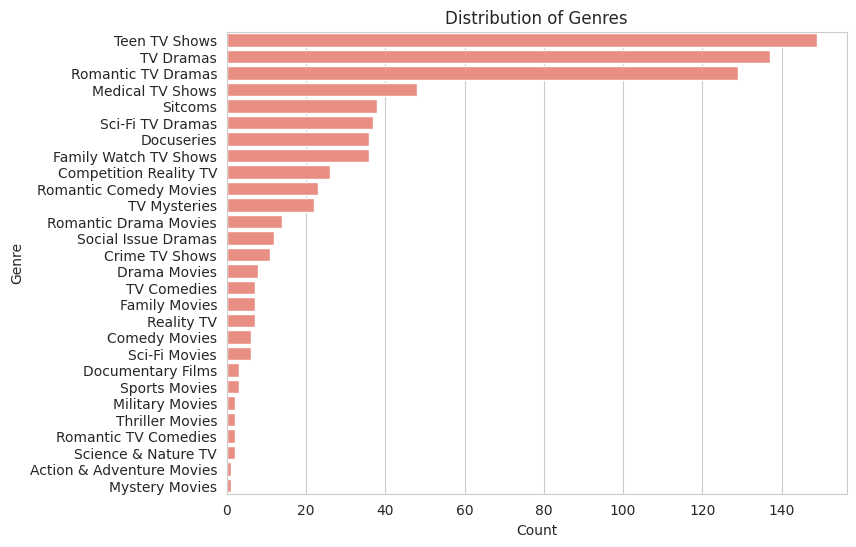

In [17]:
# Plotting the distribution of genres
plt.figure(figsize=(8, 6))
ax=sns.countplot(y='Genre', data=df, order = df['Genre'].value_counts().index, color='salmon')
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


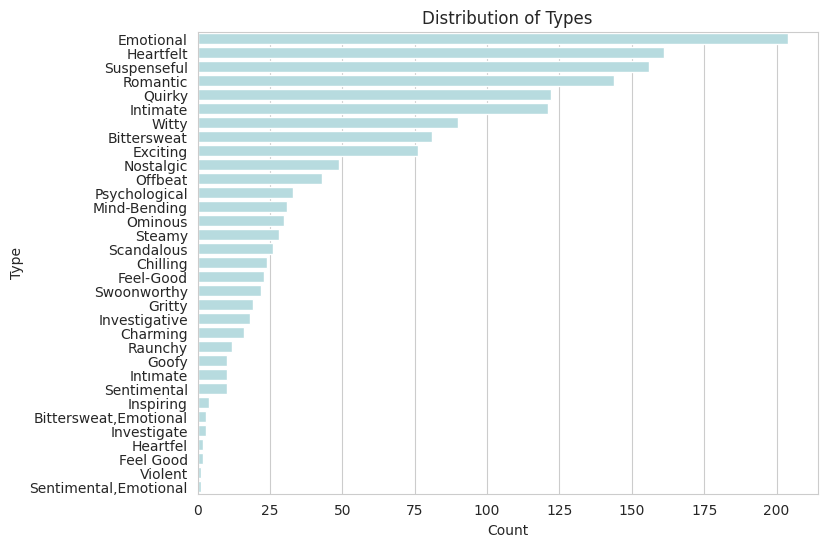

In [18]:
# Plotting the distribution of types
plt.figure(figsize=(8, 6))
sns.countplot(y='Type', data=type_exploded_df, order = type_exploded_df['Type'].value_counts().index, color='powderblue')
plt.title('Distribution of Types')
plt.xlabel('Count')
plt.ylabel('Type')
plt.show()

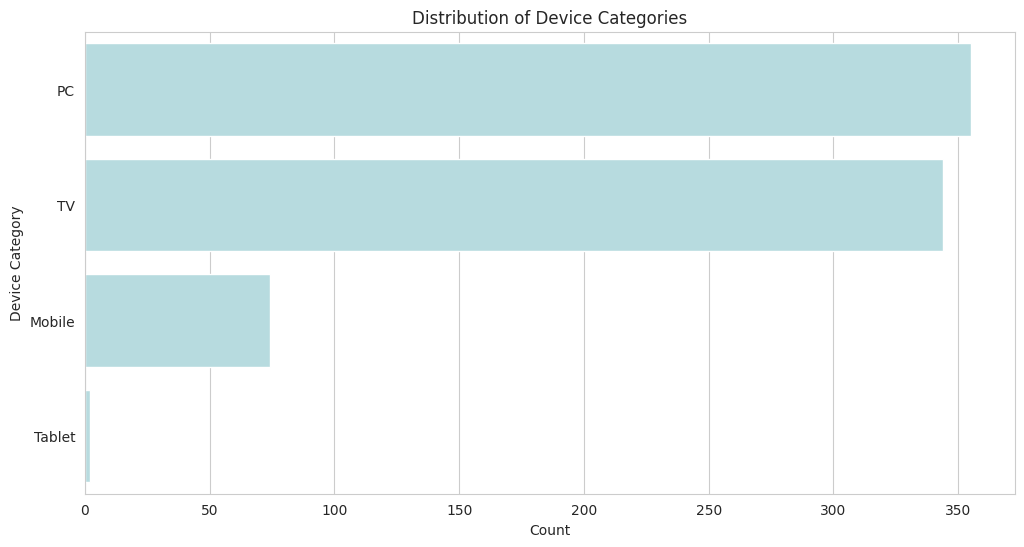

In [19]:
# Plotting the distribution of device types
plt.figure(figsize=(12, 6))
sns.countplot(y='Device Category', data=df, order = df['Device Category'].value_counts().index, color='powderblue')
plt.title('Distribution of Device Categories')
plt.xlabel('Count')
plt.ylabel('Device Category')
plt.show()

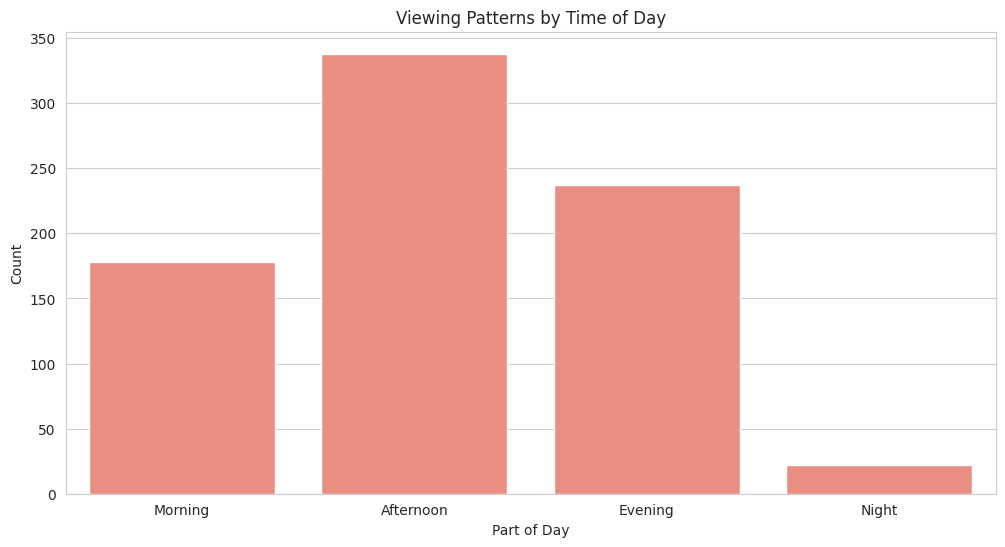

In [41]:
# Plotting viewing patterns by time of day
plt.figure(figsize=(12, 6))
sns.countplot(x='Part of Day', data=df, order = ['Morning', 'Afternoon', 'Evening', 'Night'], color='salmon')
plt.title('Viewing Patterns by Time of Day')
plt.xlabel('Part of Day')
plt.ylabel('Count')
plt.show()


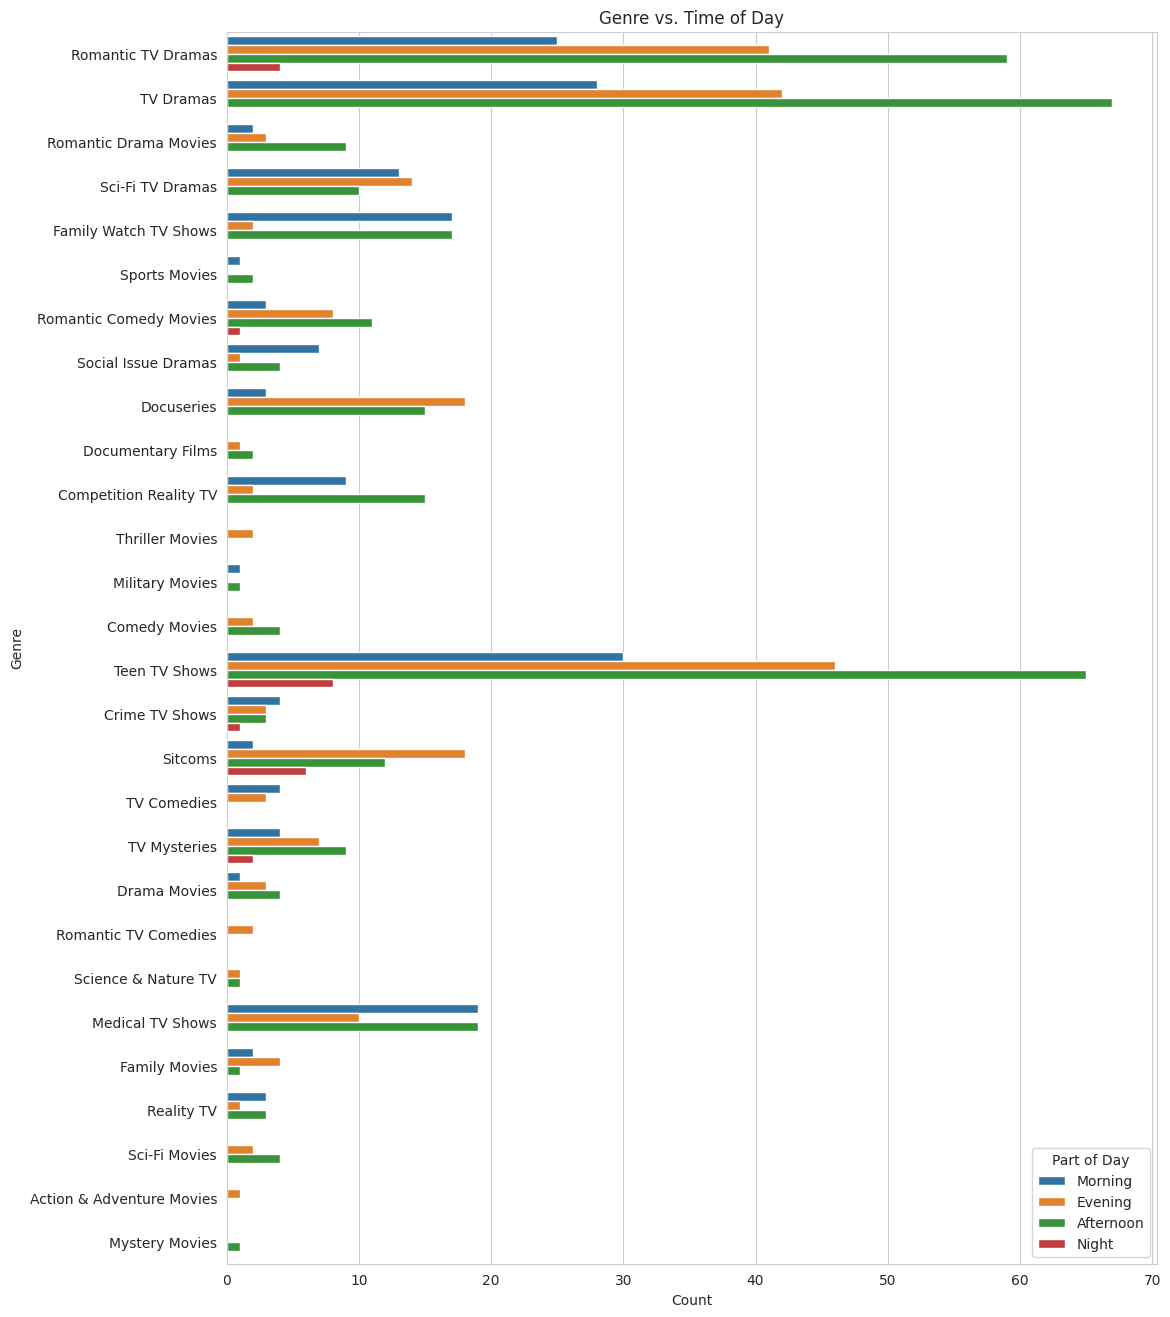

In [45]:
# Plotting the relationship between genre and time of day
plt.figure(figsize=(12, 16))
sns.countplot(y='Genre', hue='Part of Day', data=df)
plt.title('Genre vs. Time of Day')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.legend(title='Part of Day')
plt.show()

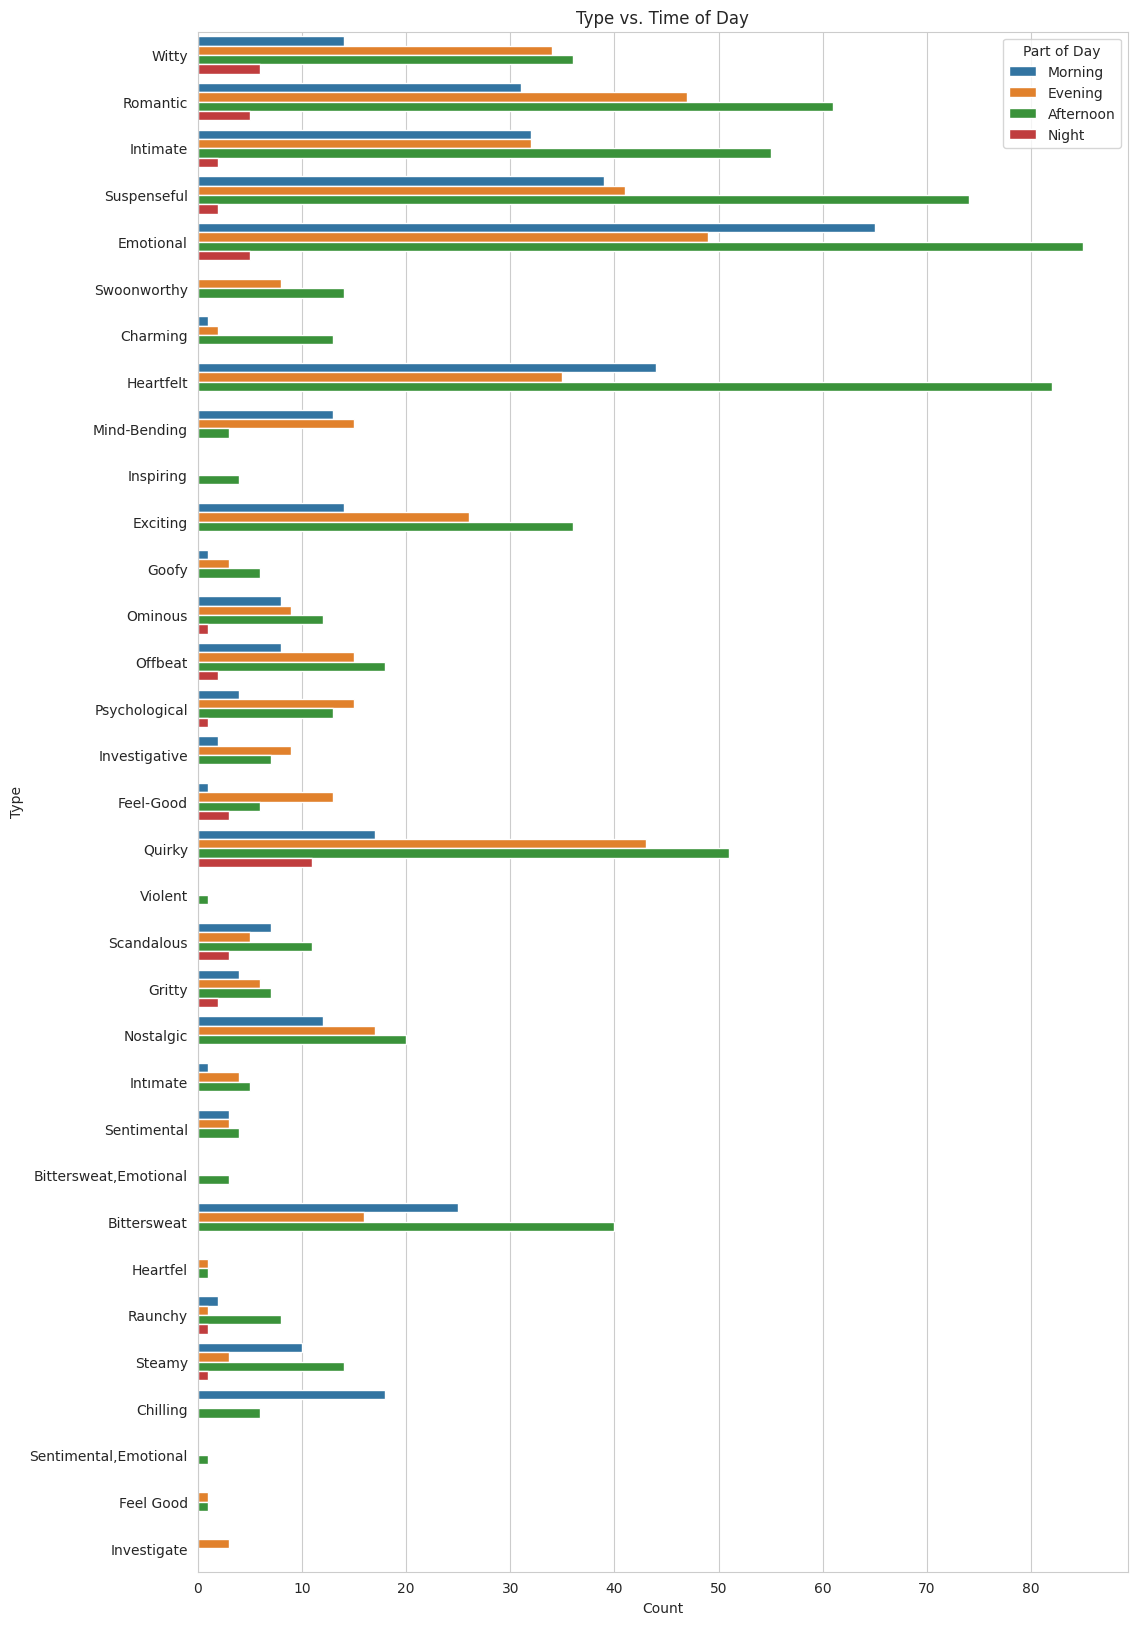

In [22]:
# Plotting the relationship between type and time of day
plt.figure(figsize=(12, 20))
sns.countplot(y='Type', hue='Part of Day', data=type_exploded_df)
plt.title('Type vs. Time of Day')
plt.xlabel('Count')
plt.ylabel('Type')
plt.legend(title='Part of Day')
plt.show()

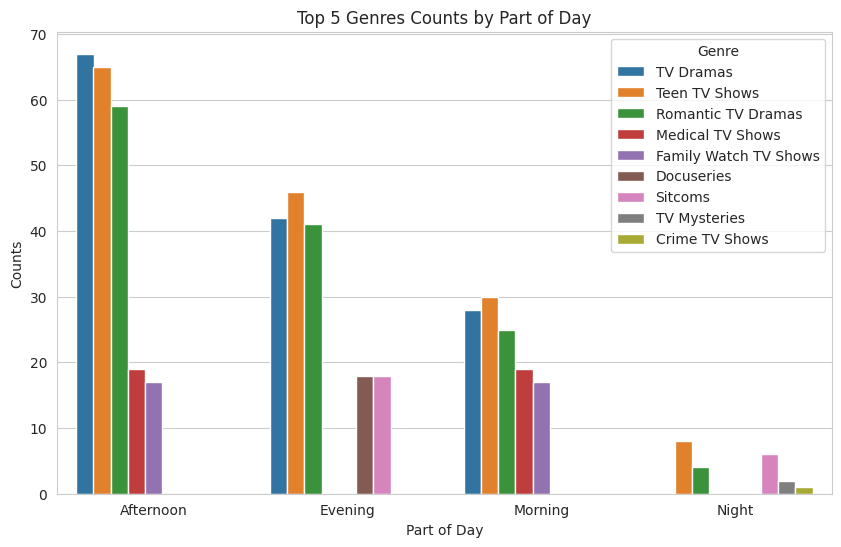

In [23]:
# Determine the top 3 genres for each part of the day
top_genres_per_part = df.groupby('Part of Day')['Genre'].value_counts().groupby(level=0).head(5).reset_index(name='Count')

# Plotting the genre counts for each part of the day
plt.figure(figsize=(10, 6))
sns.barplot(x='Part of Day', y='Count', hue='Genre', data=top_genres_per_part)
plt.title('Top 5 Genres Counts by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Counts')
plt.show()


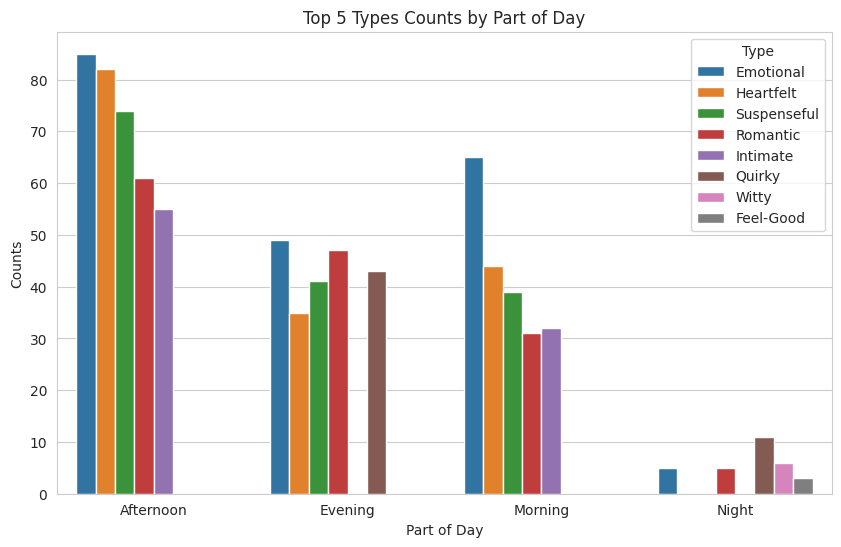

In [24]:
# Determine the top 3 types for each part of the day
top_types_per_part = type_exploded_df.groupby('Part of Day')['Type'].value_counts().groupby(level=0).head(5).reset_index(name='Count')

# Plotting the genre counts for each part of the day
plt.figure(figsize=(10, 6))
sns.barplot(x='Part of Day', y='Count', hue='Type', data=top_types_per_part)
plt.title('Top 5 Types Counts by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Counts')
plt.show()

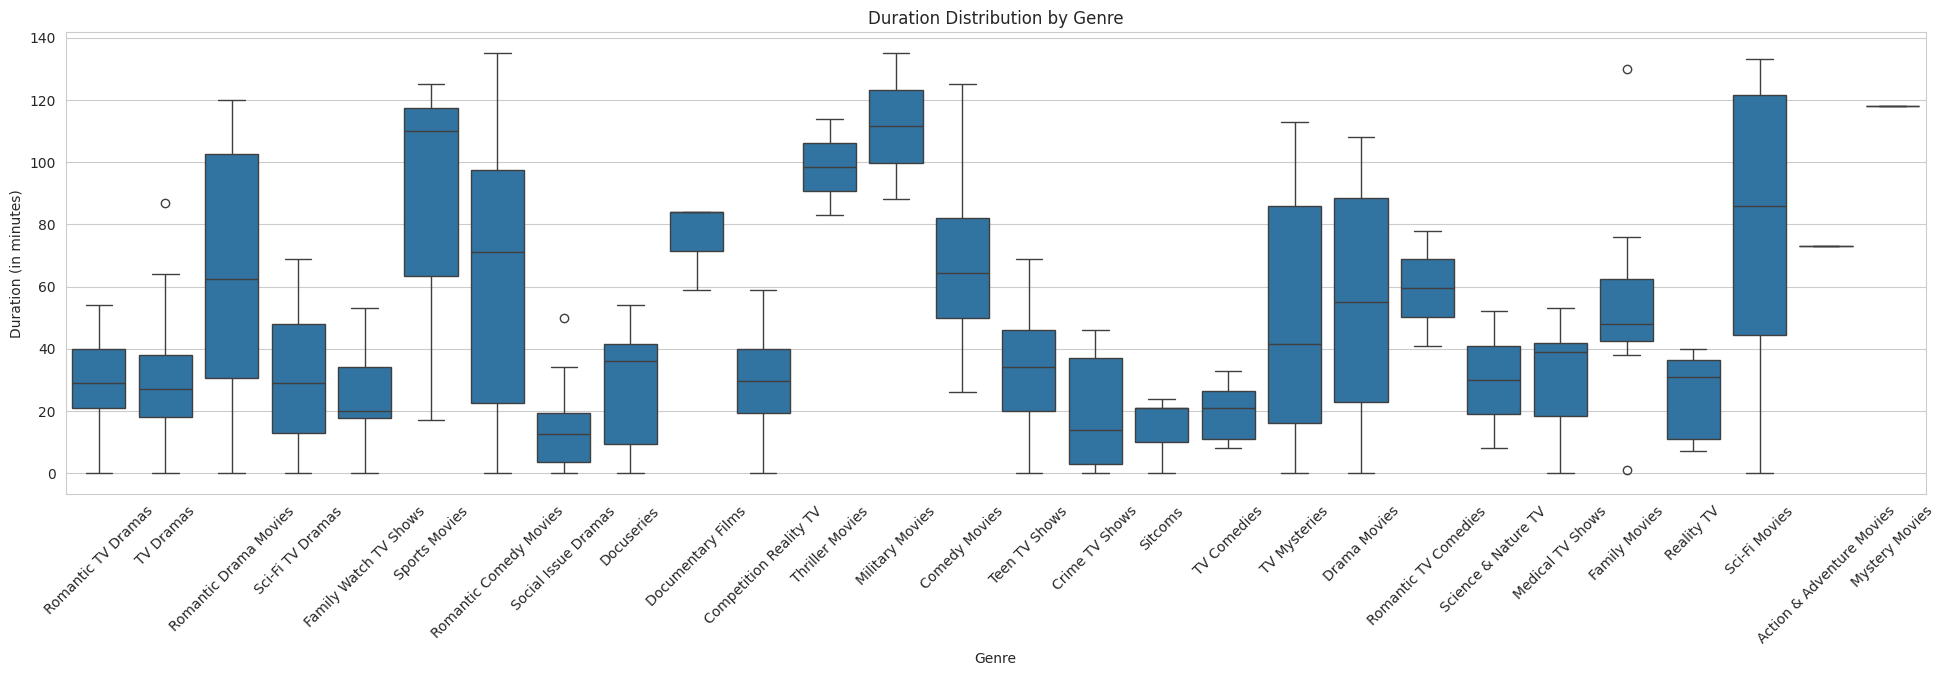

In [25]:
# Plotting the distribution of viewing duration by genre
plt.figure(figsize=(24, 6))
sns.boxplot(x='Genre', y='Duration', data=df)
plt.xticks(rotation=45)
plt.title('Duration Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Duration (in minutes)')
plt.show()

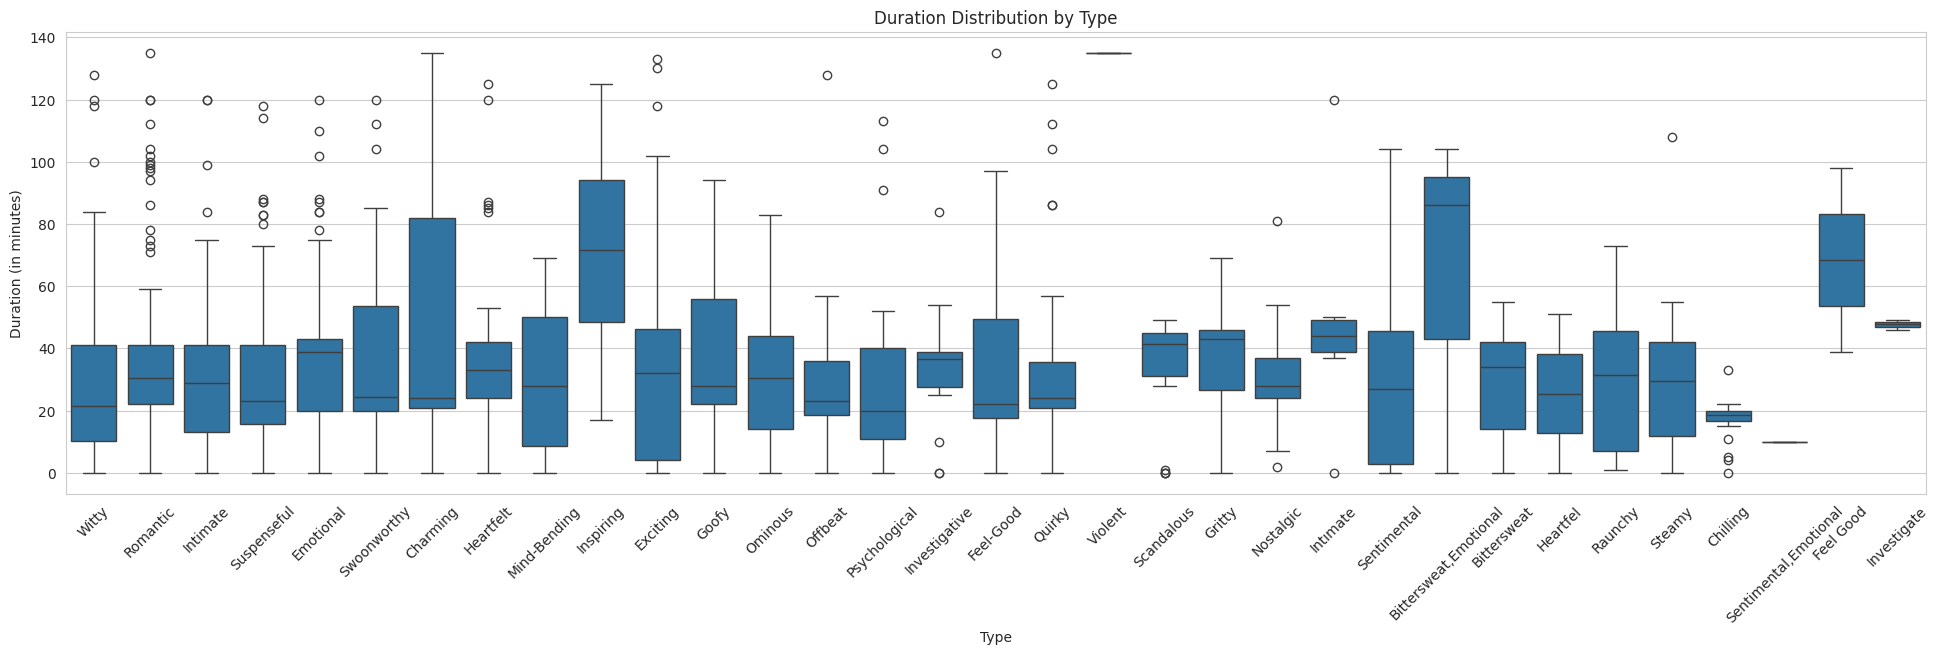

In [26]:
# Plotting the distribution of viewing duration by type
plt.figure(figsize=(24, 6))
sns.boxplot(x='Type', y='Duration', data=type_exploded_df)
plt.xticks(rotation=45)
plt.title('Duration Distribution by Type')
plt.xlabel('Type')
plt.ylabel('Duration (in minutes)')
plt.show()

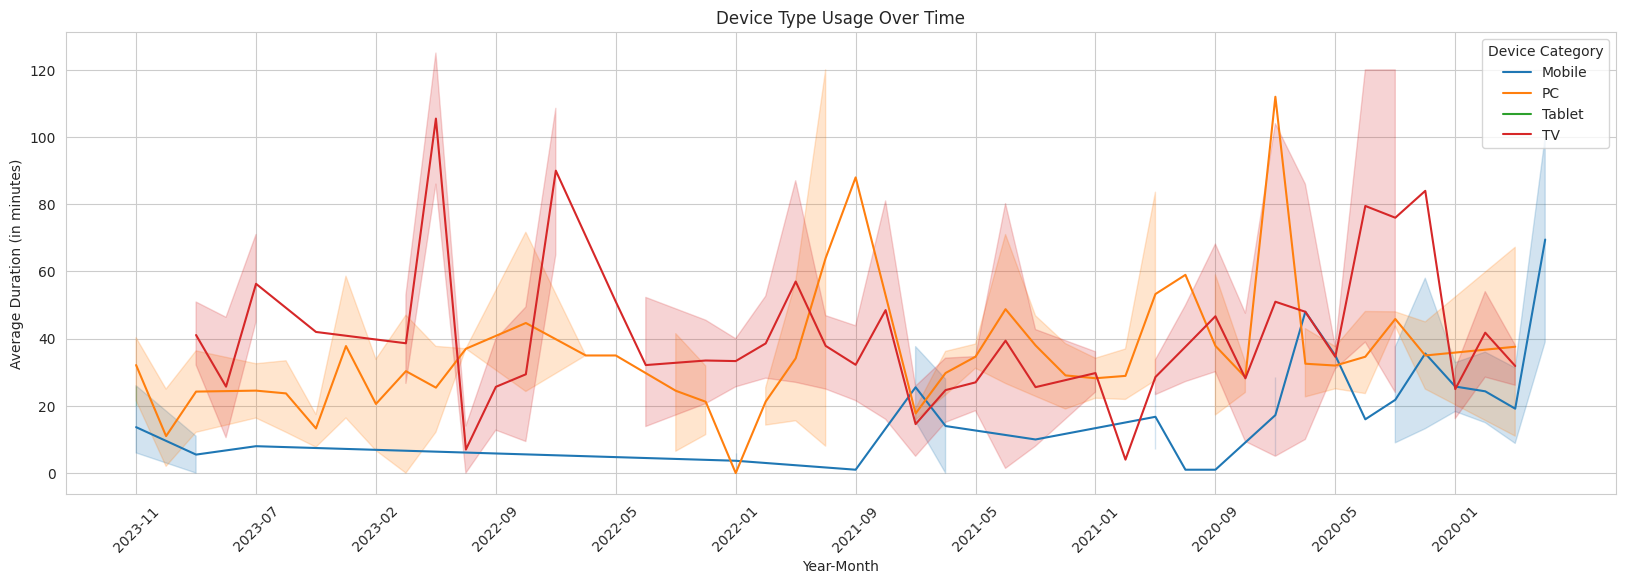

In [27]:
# Extract year and month from 'Date' for trend over time
df['YearMonth'] = df['Date'].apply(lambda x: x.strftime('%Y-%m'))

# Plotting device type usage over time
plt.figure(figsize=(20, 6))
sns.lineplot(x='YearMonth', y='Duration', hue='Device Category', data=df)
plt.xticks(df['YearMonth'].unique()[::4], rotation=45)  # Display every 4th month plt.xticks(rotation=45)
plt.title('Device Type Usage Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Average Duration (in minutes)')
plt.legend(title='Device Category')
plt.show()

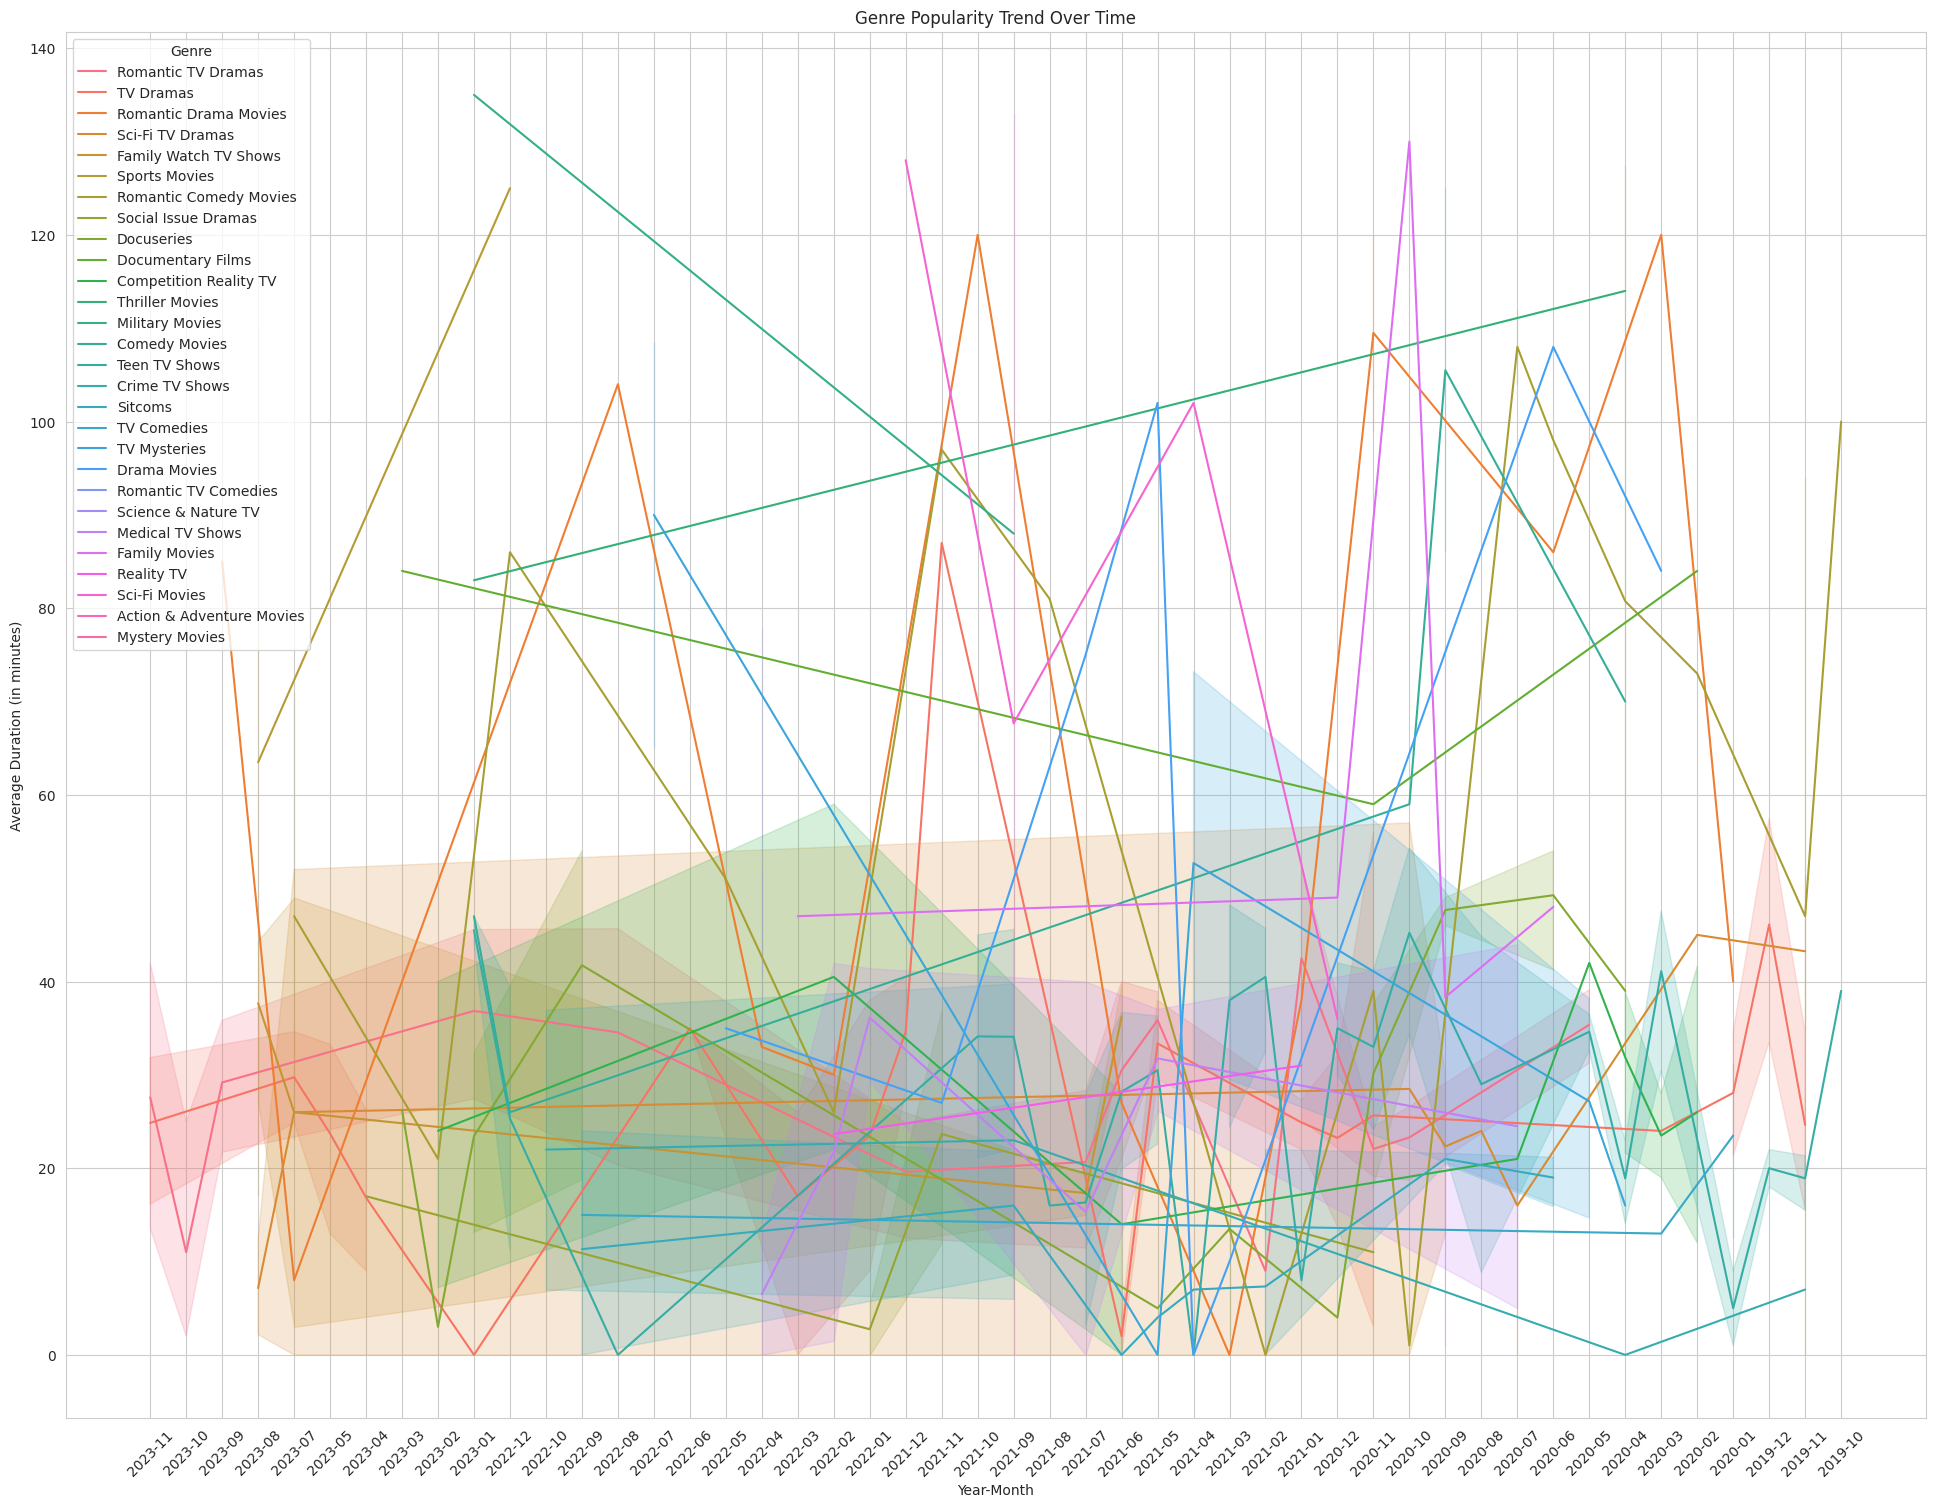

In [28]:
# Plotting genre popularity over time
plt.figure(figsize=(24, 18))
sns.lineplot(x='YearMonth', y='Duration', hue='Genre', data=df)
plt.xticks(rotation=45)
plt.title('Genre Popularity Trend Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Average Duration (in minutes)')
plt.legend(title='Genre', loc='upper left')
plt.show()

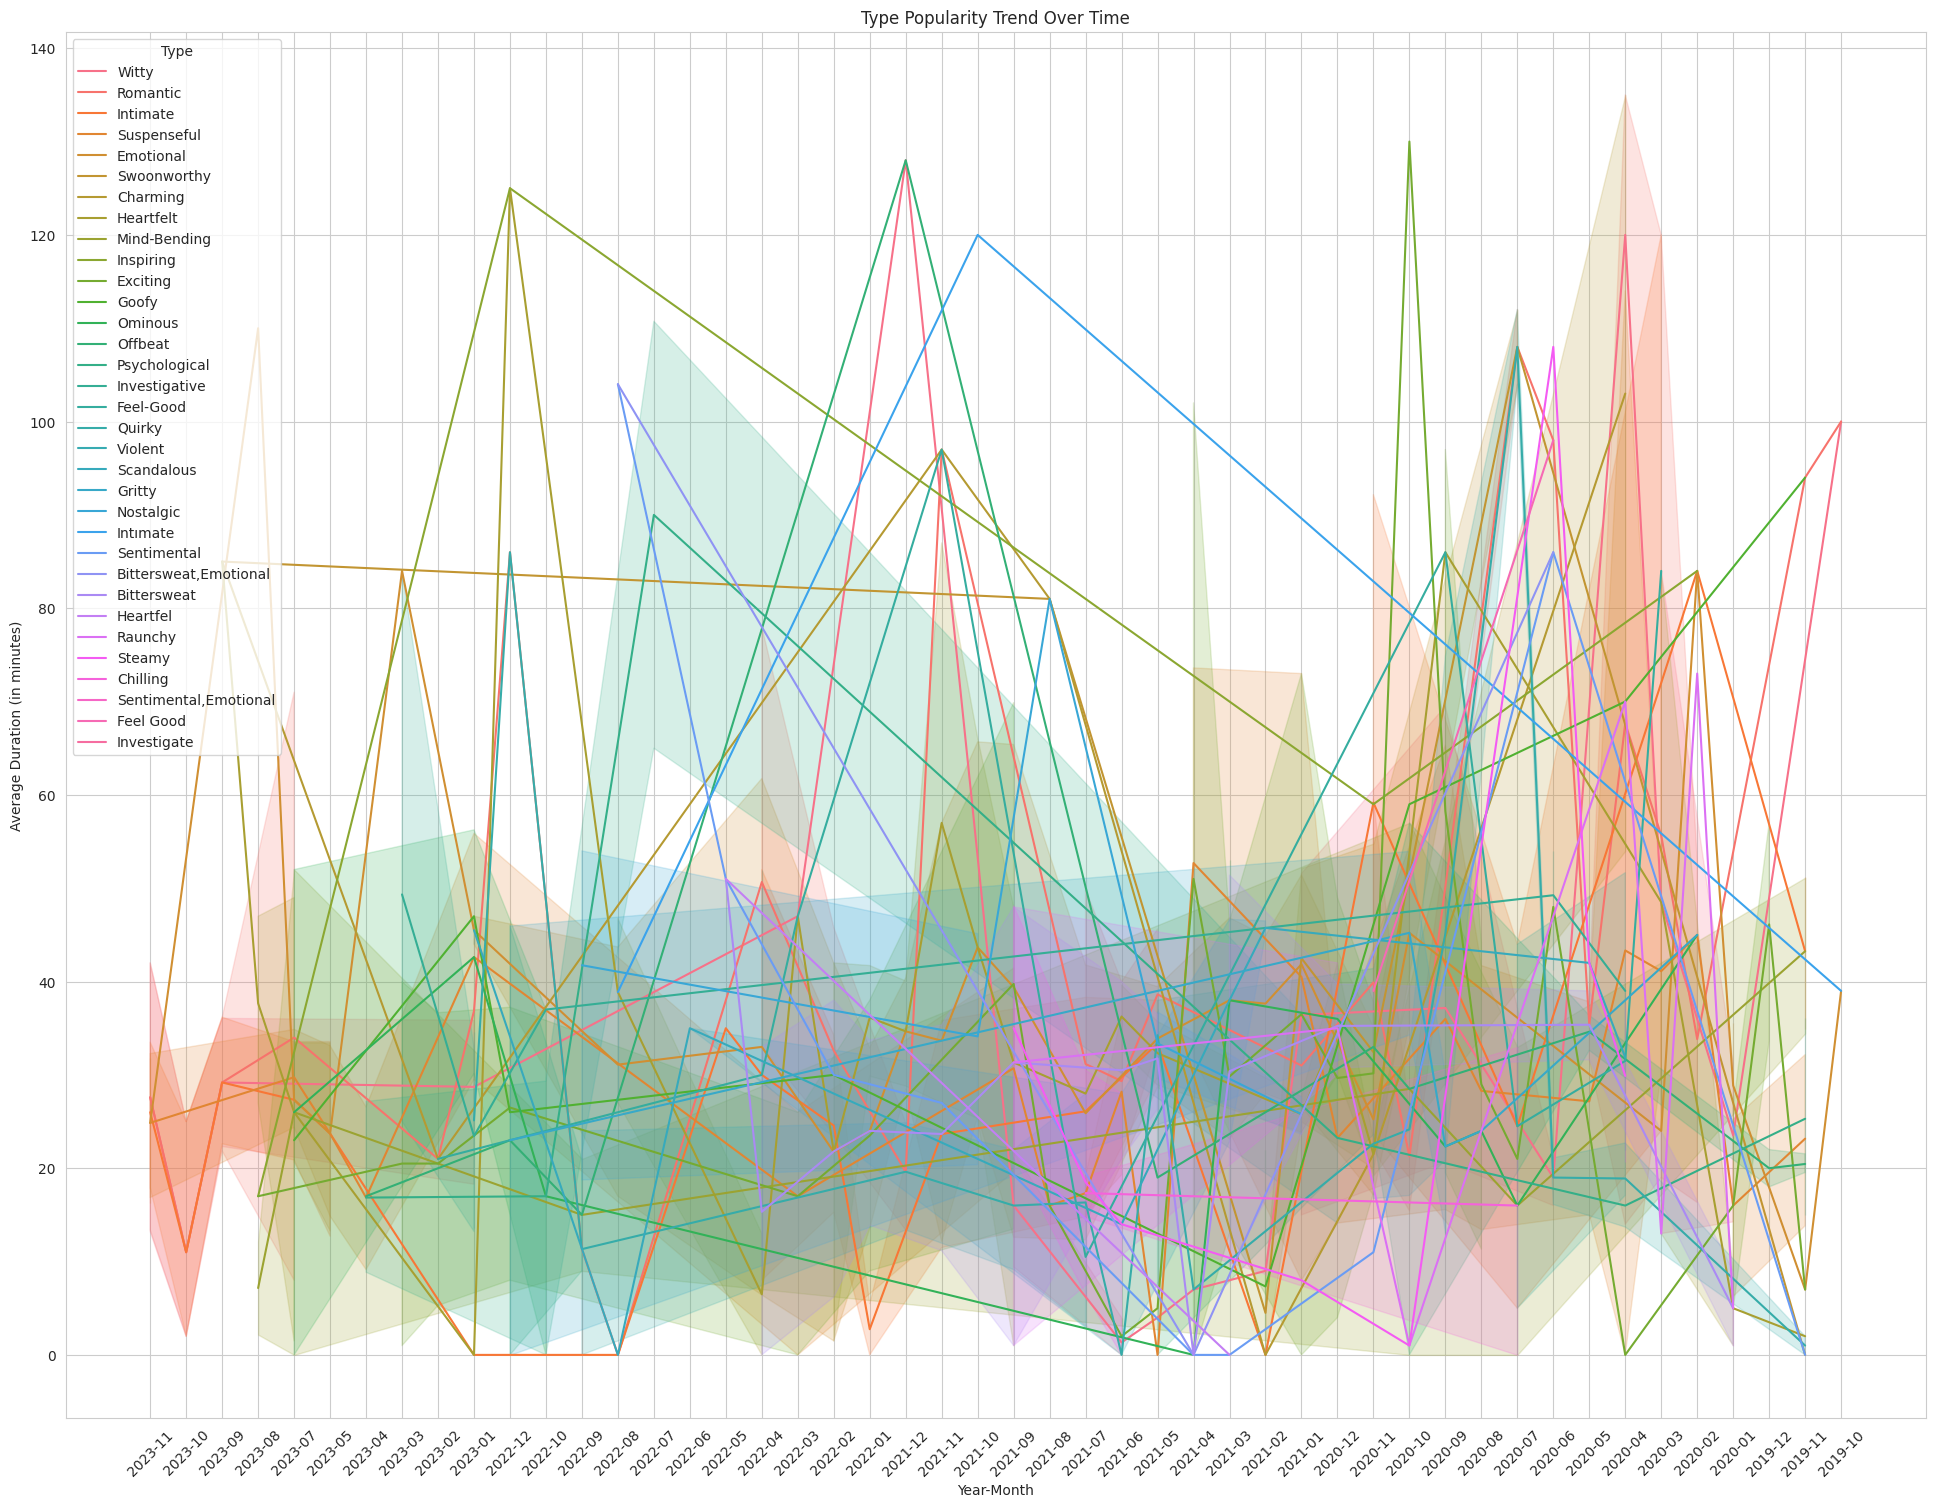

In [29]:
# Plotting type popularity over time
type_exploded_df['YearMonth'] = type_exploded_df['Date'].apply(lambda x: x.strftime('%Y-%m'))
plt.figure(figsize=(24, 18))
sns.lineplot(x='YearMonth', y='Duration', hue='Type', data=type_exploded_df)
plt.xticks(rotation=45)
plt.title('Type Popularity Trend Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Average Duration (in minutes)')
plt.legend(title='Type', loc='upper left')
plt.show()

<ipython-input-30-d878504e806f>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_encoded.corr(), annot=True, cmap='rocket_r')


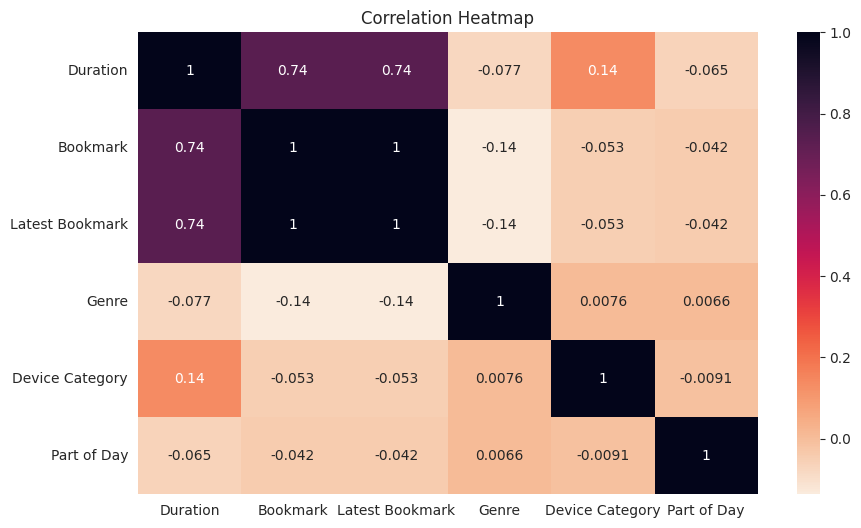

In [30]:
# Convert categorical data to numeric for correlation analysis
df_encoded = df.copy()
df_encoded['Genre'] = df_encoded['Genre'].astype('category').cat.codes
df_encoded['Device Category'] = df_encoded['Device Category'].astype('category').cat.codes
df_encoded['Part of Day'] = df_encoded['Part of Day'].astype('category').cat.codes

# Creating a heatmap to visualize correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='rocket_r')
plt.title('Correlation Heatmap')
plt.show()

<ipython-input-31-e01091e5cc1f>:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(type_exploded_df_encoded.corr(), annot=True, cmap='rocket_r')


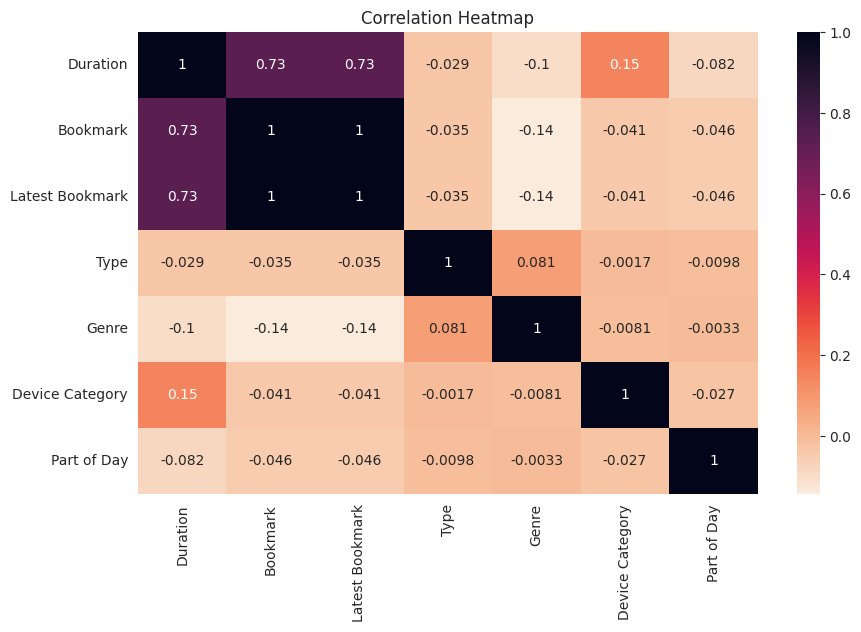

In [31]:
# Convert categorical data to numeric for correlation analysis
# Here, columns other than Type should be overlooked since I exploded Type column and this will make other columns meaningless since most rows are duplicated during explosion
# This correlation map is a bit meaningless at the moment because of row duplication however it can still give an insight about the correleations
type_exploded_df_encoded = type_exploded_df.copy()
type_exploded_df_encoded['Genre'] = type_exploded_df_encoded['Genre'].astype('category').cat.codes
type_exploded_df_encoded['Device Category'] = type_exploded_df_encoded['Device Category'].astype('category').cat.codes
type_exploded_df_encoded['Part of Day'] = type_exploded_df_encoded['Part of Day'].astype('category').cat.codes
type_exploded_df_encoded['Type'] = type_exploded_df_encoded['Type'].astype('category').cat.codes


# Creating a heatmap to visualize correlations
plt.figure(figsize=(10, 6))
sns.heatmap(type_exploded_df_encoded.corr(), annot=True, cmap='rocket_r')
plt.title('Correlation Heatmap')
plt.show()

## In-Depth Analysis and Hypothesis Testing

Chi-Square Test for Genre and Time of Day: Chi2 = 146.8394655700063, p-value = 1.063536700336629e-05


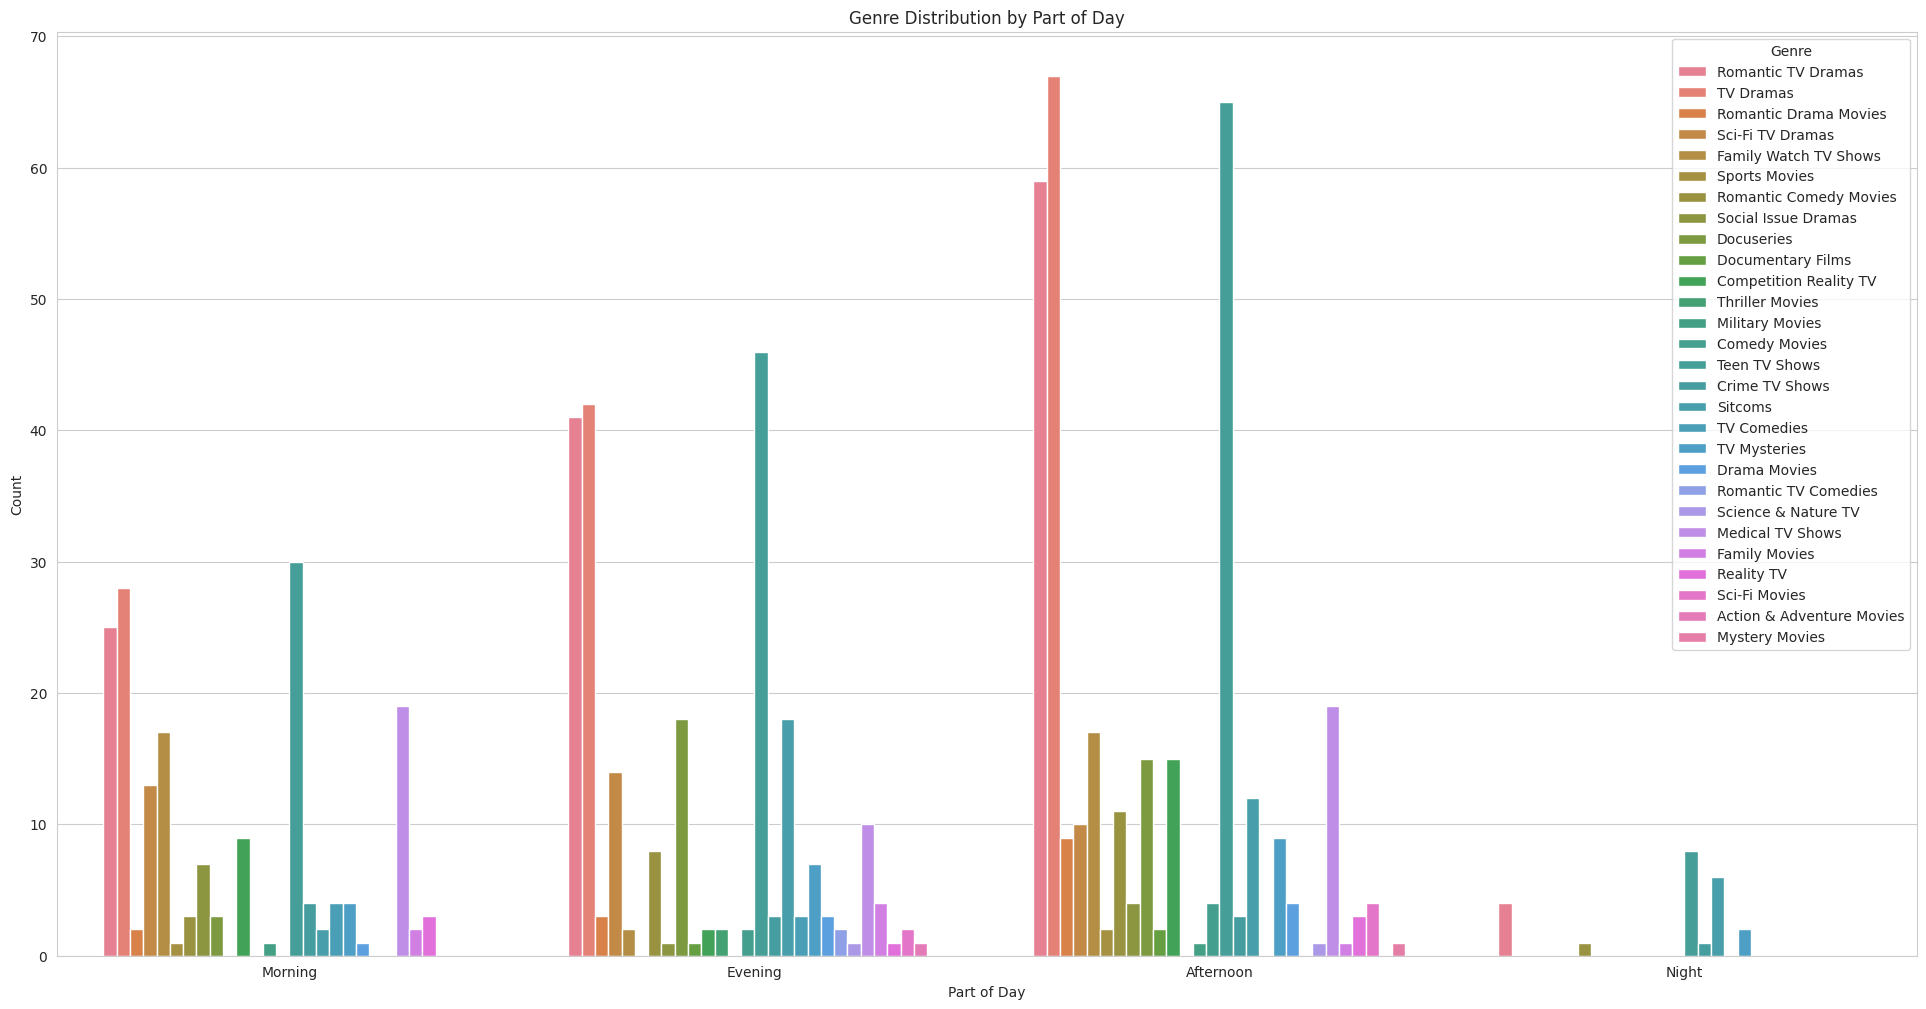

In [32]:
# Creating a contingency table for genre and part of the day
contingency_table_genre = pd.crosstab(df['Part of Day'], df['Genre'])

# Performing the Chi-Square Test
chi2, p_genre, dof, expected = chi2_contingency(contingency_table_genre)
print(f"Chi-Square Test for Genre and Time of Day: Chi2 = {chi2}, p-value = {p_genre}")

# Visualizing the relationship
plt.figure(figsize=(24, 12))
sns.countplot(x='Part of Day', hue='Genre', data=df)
plt.title('Genre Distribution by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Count')
plt.show()

Chi-Square Test for Type and Time of Day: Chi2 = 216.193823330799, p-value = 2.9737688535351456e-11


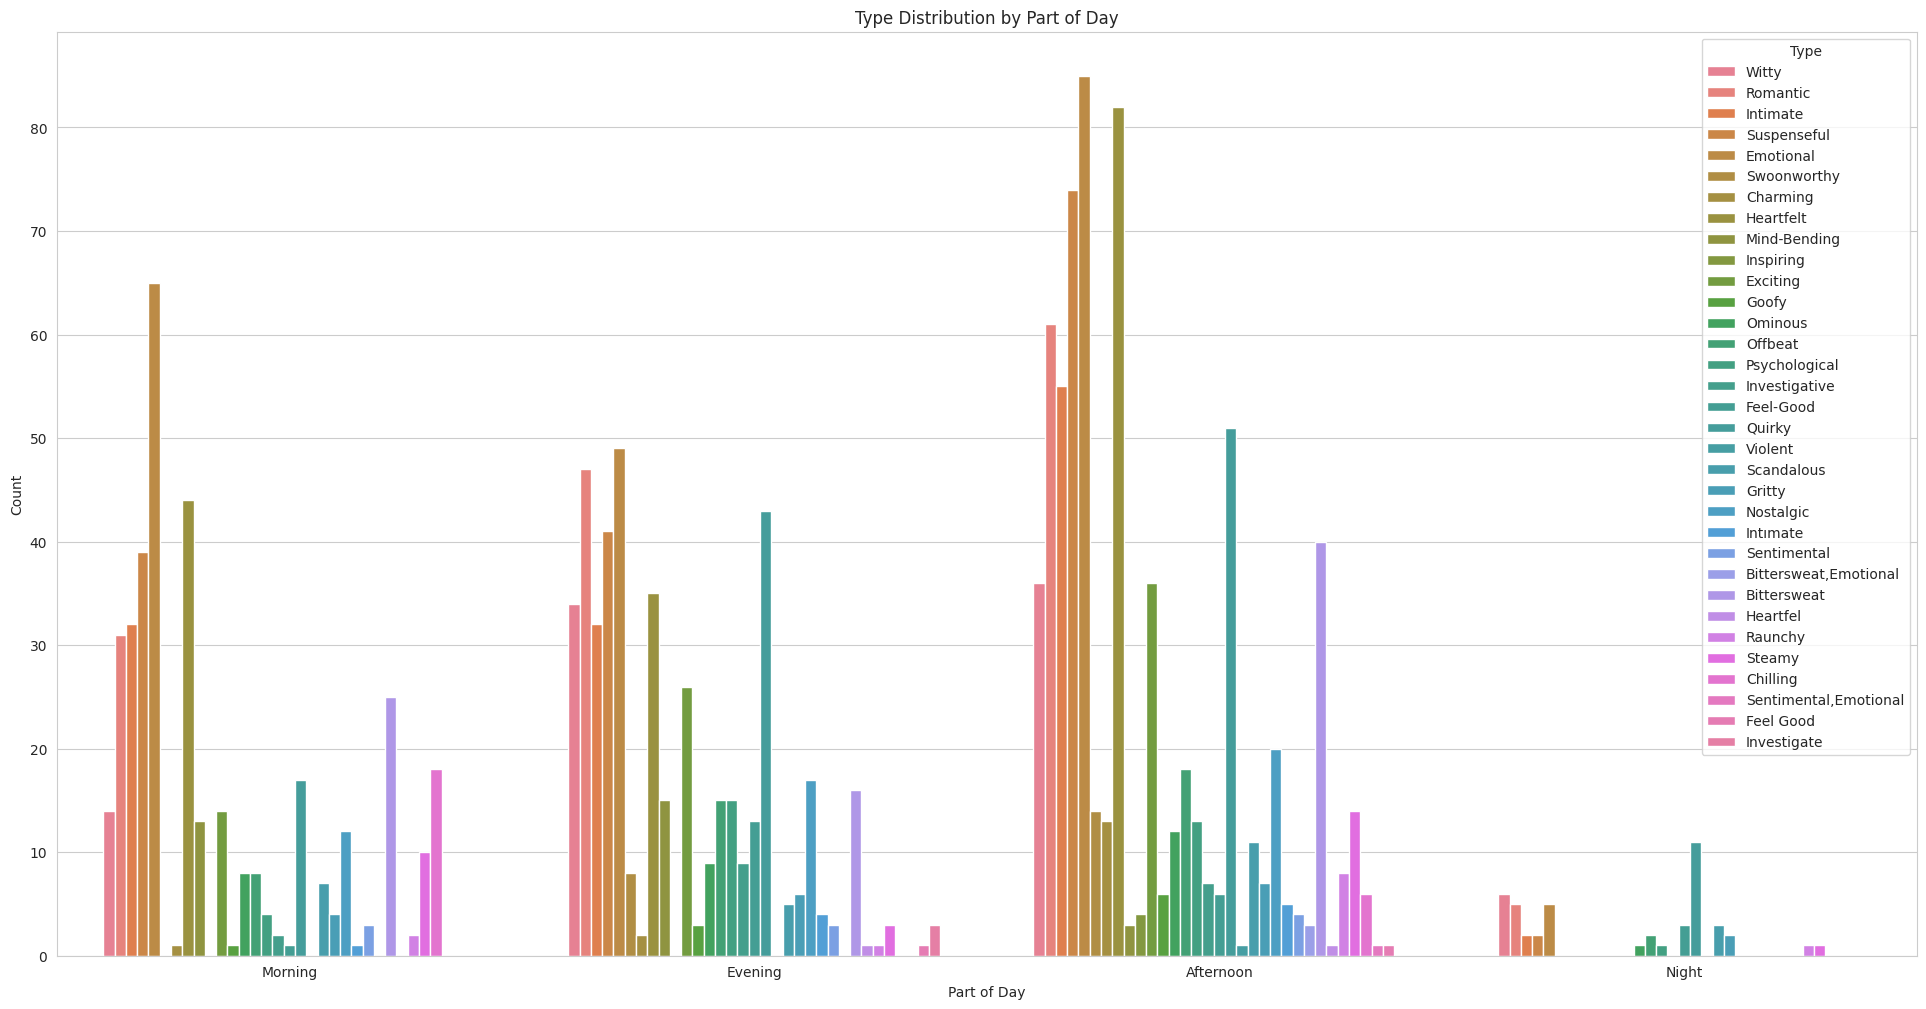

In [33]:
# Creating a contingency table for type and part of the day
contingency_table_type= pd.crosstab(type_exploded_df['Part of Day'], type_exploded_df['Type'])

# Performing the Chi-Square Test
chi2T, p_type, dofT, expectedT = chi2_contingency(contingency_table_type)
print(f"Chi-Square Test for Type and Time of Day: Chi2 = {chi2T}, p-value = {p_type}")

# Visualizing the relationship
plt.figure(figsize=(24, 12))
sns.countplot(x='Part of Day', hue='Type', data=type_exploded_df)
plt.title('Type Distribution by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Count')
plt.show()

Chi-Square Test for Device Type and Time of Day: Chi2 = 32.031872334115285, p-value = 0.0001966181514066283


<ipython-input-34-e91977f9b307>:11: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.countplot(x='Part of Day', hue='Device Category', data=df, palette=custom_palette)


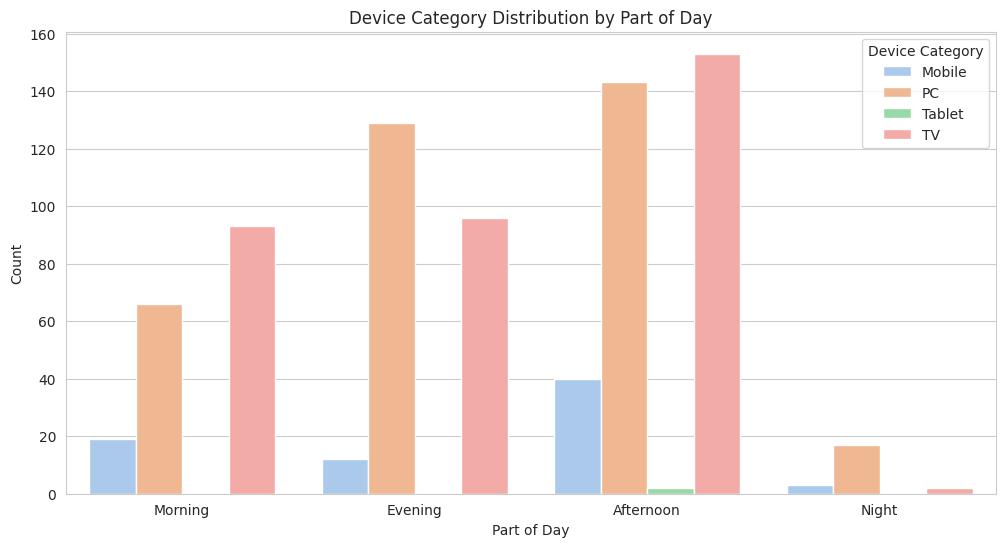

In [34]:
# Creating a contingency table for device type and part of the day
contingency_table_device = pd.crosstab(df['Part of Day'], df['Device Category'])

# Performing the Chi-Square Test
chi2D, p_device, dofD, expectedD = chi2_contingency(contingency_table_device)
print(f"Chi-Square Test for Device Type and Time of Day: Chi2 = {chi2D}, p-value = {p_device}")

# Visualizing the relationship
plt.figure(figsize=(12, 6))
custom_palette = sns.color_palette("pastel")
sns.countplot(x='Part of Day', hue='Device Category', data=df, palette=custom_palette)
plt.title('Device Category Distribution by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Count')
plt.show()

<Figure size 2400x3200 with 0 Axes>

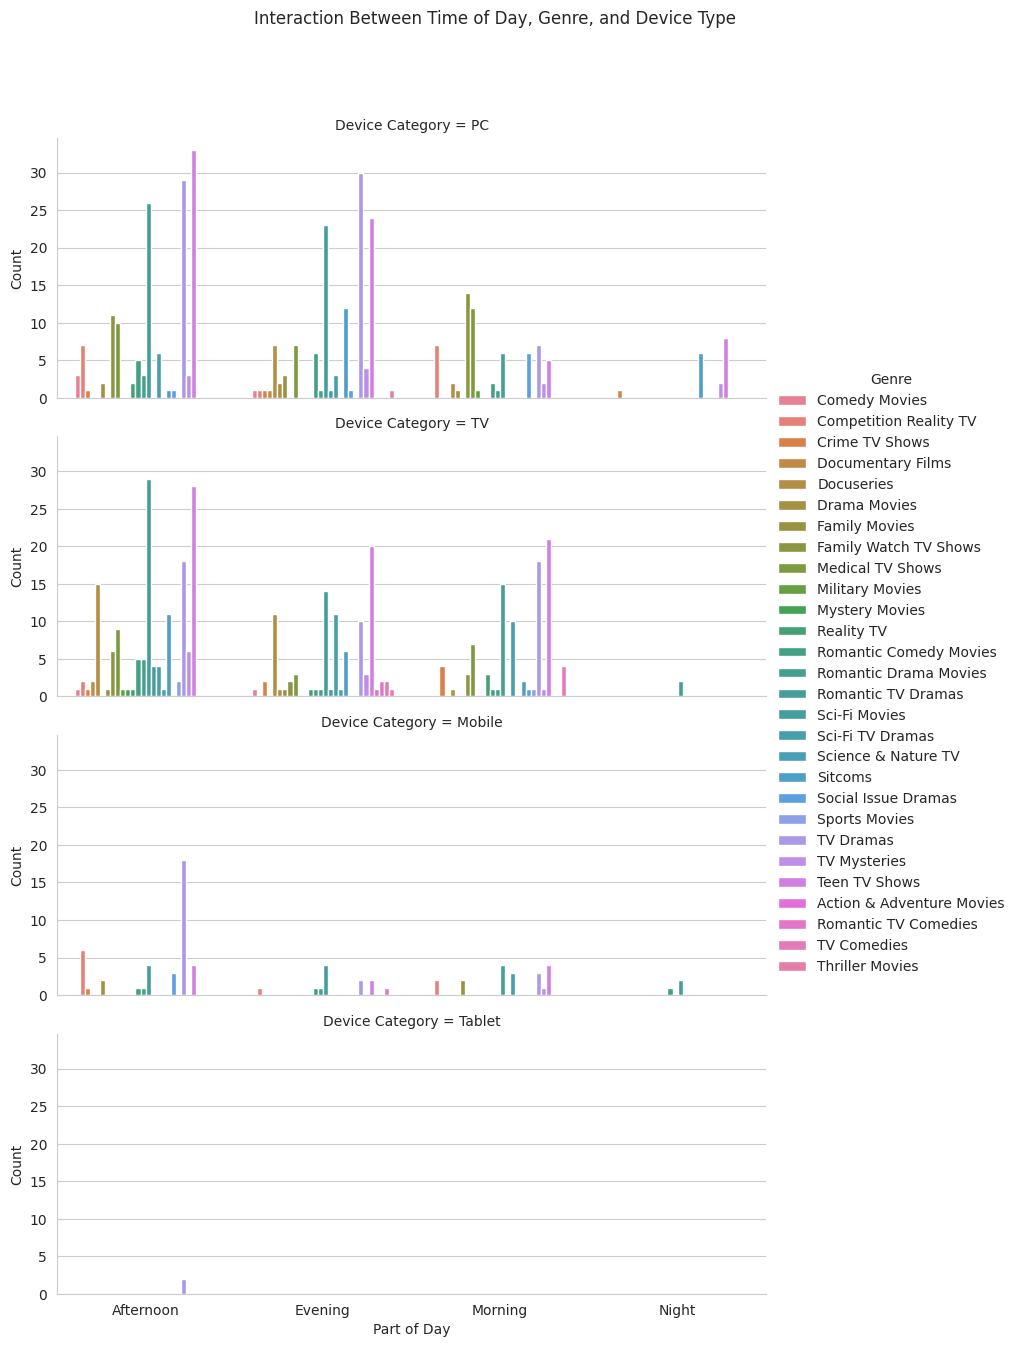

In [35]:
# Aggregating data for interaction effect
interaction_data = df.groupby(['Part of Day', 'Genre', 'Device Category']).size().reset_index(name='Count')

# Visualizing the interaction effect with vertical arrangement
plt.figure(figsize=(24, 32))
sns.catplot(x='Part of Day', y='Count', hue='Genre', row='Device Category',
            data=interaction_data, kind='bar', height=4, aspect=2)
plt.subplots_adjust(top=0.9)
plt.suptitle('Interaction Between Time of Day, Genre, and Device Type')
plt.show()




<ipython-input-39-428ae3ddc871>:9: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.countplot(x='Part of Day', hue='Device Category', data=myDataR, palette=custom_palette)


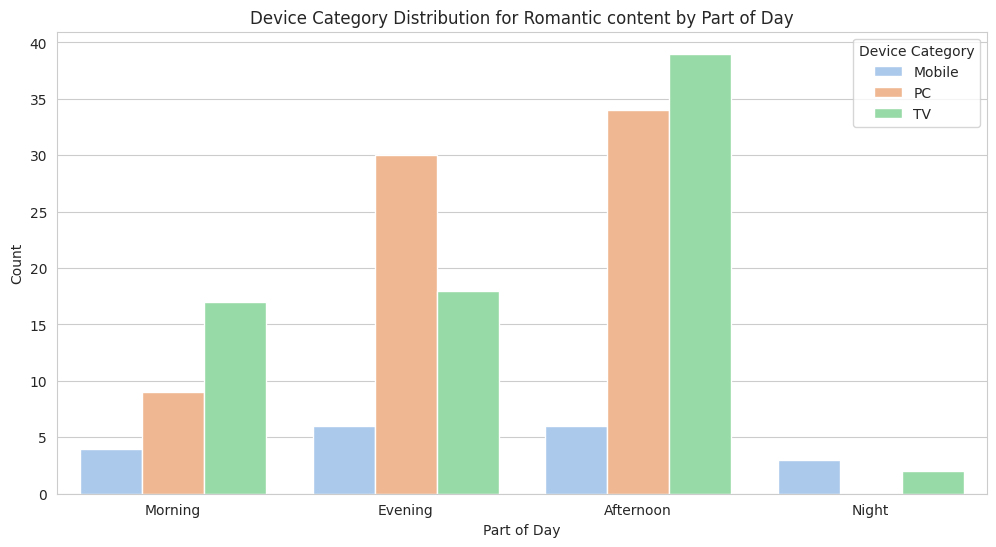

In [39]:
# Define the genres of interest
selected_genres = ["Romantic Drama Movies", "Romantic TV Dramas",
                   "Romantic Comedy Movies", "Romantic TV Comedies", "Romantic Dramas"]

myDataR = df[df['Genre'].isin(selected_genres)]

plt.figure(figsize=(12, 6))
custom_palette = sns.color_palette("pastel")
sns.countplot(x='Part of Day', hue='Device Category', data=myDataR, palette=custom_palette)
plt.title('Device Category Distribution for Romantic content by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Count')
plt.show()

<ipython-input-38-d8013f8369a5>:8: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.countplot(x='Part of Day', hue='Device Category', data=myDataC, palette=custom_palette)


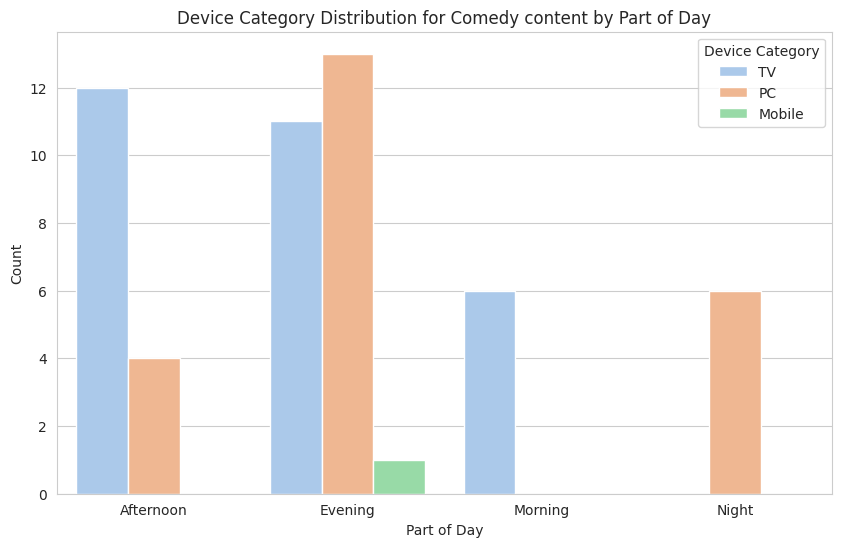

In [38]:
# Define the genres of interest
selected_genres = ["Comedy Movies", "Sitcoms", "Romantic TV Comedies", "TV Comedies"]

myDataC = df[df['Genre'].isin(selected_genres)]

plt.figure(figsize=(10, 6))
custom_palette = sns.color_palette("pastel")
sns.countplot(x='Part of Day', hue='Device Category', data=myDataC, palette=custom_palette)
plt.title('Device Category Distribution for Comedy content by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Count')
plt.show()

